In [1]:
import time, os, pickle
import joblib
import pandas as pd
import numpy as np
import math
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import missingno as msno
import plotly.graph_objects as go
from datetime import datetime
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.model_selection import KFold, train_test_split,GridSearchCV
from sklearn.preprocessing import MinMaxScaler,MaxAbsScaler,RobustScaler,StandardScaler
from sklearn.feature_selection import VarianceThreshold,mutual_info_classif, f_classif
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, precision_score, recall_score
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.metrics import roc_auc_score, mean_squared_error
from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import f_classif, mutual_info_classif, VarianceThreshold
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
import xgboost as xgb
from imblearn.over_sampling import SMOTE
from feature_engine.selection import (
    RecursiveFeatureElimination,
    DropConstantFeatures,
    DropDuplicateFeatures,
)
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from operator import itemgetter
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    roc_curve,
    classification_report,
    confusion_matrix
)


#to ignore warnings
import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_rows', None)  # Show all rows
pd.set_option('display.max_columns', None)  # Show all columns
pd.set_option('display.width', None)  # Allow long lines

In [2]:
# Specify the path to the CSV file in the parent directory
file_path = "../Dataset/pd_speech_features/pd_speech_features.csv"

# Read the CSV file into a DataFrame
df = pd.read_csv(file_path, sep=',',skiprows=1)

In [3]:
df.head()

,id,gender,PPE,DFA,RPDE,numPulses,numPeriodsPulses,meanPeriodPulses,stdDevPeriodPulses,locPctJitter,locAbsJitter,rapJitter,ppq5Jitter,ddpJitter,locShimmer,locDbShimmer,apq3Shimmer,apq5Shimmer,apq11Shimmer,ddaShimmer,meanAutoCorrHarmonicity,meanNoiseToHarmHarmonicity,meanHarmToNoiseHarmonicity,minIntensity,maxIntensity,meanIntensity,f1,f2,f3,f4,b1,b2,b3,b4,GQ_prc5_95,GQ_std_cycle_open,GQ_std_cycle_closed,GNE_mean,GNE_std,GNE_SNR_TKEO,GNE_SNR_SEO,GNE_NSR_TKEO,GNE_NSR_SEO,VFER_mean,VFER_std,VFER_entropy,VFER_SNR_TKEO,VFER_SNR_SEO,VFER_NSR_TKEO,VFER_NSR_SEO,IMF_SNR_SEO,IMF_SNR_TKEO,IMF_SNR_entropy,IMF_NSR_SEO,IMF_NSR_TKEO,IMF_NSR_entropy,mean_Log_energy,mean_MFCC_0th_coef,mean_MFCC_1st_coef,mean_MFCC_2nd_coef,mean_MFCC_3rd_coef,mean_MFCC_4th_coef,mean_MFCC_5th_coef,mean_MFCC_6th_coef,mean_MFCC_7th_coef,mean_MFCC_8th_coef,mean_MFCC_9th_coef,mean_MFCC_10th_coef,mean_MFCC_11th_coef,mean_MFCC_12th_coef,mean_delta_log_energy,mean_0th_delta,mean_1st_delta,mean_2nd_delta,mean_3rd_delta,mean_4th_delta,mean_5th_delta,mean_6th_delta,mean_7th_delta,mean_8th_delta,mean_9th_delta,mean_10th_delta,mean_11th_delta,mean_12th_delta,mean_delta_delta_log_energy,mean_delta_delta_0th,mean_1st_delta_delta,mean_2nd_delta_delta,mean_3rd_delta_delta,mean_4th_delta_delta,mean_5th_delta_delta,mean_6th_delta_delta,mean_7th_delta_delta,mean_8th_delta_delta,mean_9th_delta_delta,mean_10th_delta_delta,mean_11th_delta_delta,mean_12th_delta_delta,std_Log_energy,std_MFCC_0th_coef,std_MFCC_1st_coef,std_MFCC_2nd_coef,std_MFCC_3rd_coef,std_MFCC_4th_coef,std_MFCC_5th_coef,std_MFCC_6th_coef,std_MFCC_7th_coef,std_MFCC_8th_coef,std_MFCC_9th_coef,std_MFCC_10th_coef,std_MFCC_11th_coef,std_MFCC_12th_coef,std_delta_log_energy,std_0th_delta,std_1st_delta,std_2nd_delta,std_3rd_delta,std_4th_delta,std_5th_delta,std_6th_delta,std_7th_delta,std_8th_delta,std_9th_delta,std_10th_delta,std_11th_delta,std_12th_delta,std_delta_delta_log_energy,std_delta_delta_0th,std_1st_delta_delta,std_2nd_delta_delta,std_3rd_delta_delta,std_4th_delta_delta,std_5th_delta_delta,std_6th_delta_delta,std_7th_delta_delta,std_8th_delta_delta,std_9th_delta_delta,std_10th_delta_delta,std_11th_delta_delta,std_12th_delta_delta,Ea,Ed_1_coef,Ed_2_coef,Ed_3_coef,Ed_4_coef,Ed_5_coef,Ed_6_coef,Ed_7_coef,Ed_8_coef,Ed_9_coef,Ed_10_coef,det_entropy_shannon_1_coef,det_entropy_shannon_2_coef,det_entropy_shannon_3_coef,det_entropy_shannon_4_coef,det_entropy_shannon_5_coef,det_entropy_shannon_6_coef,det_entropy_shannon_7_coef,det_entropy_shannon_8_coef,det_entropy_shannon_9_coef,det_entropy_shannon_10_coef,det_entropy_log_1_coef,det_entropy_log_2_coef,det_entropy_log_3_coef,det_entropy_log_4_coef,det_entropy_log_5_coef,det_entropy_log_6_coef,det_entropy_log_7_coef,det_entropy_log_8_coef,det_entropy_log_9_coef,det_entropy_log_10_coef,det_TKEO_mean_1_coef,det_TKEO_mean_2_coef,det_TKEO_mean_3_coef,det_TKEO_mean_4_coef,det_TKEO_mean_5_coef,det_TKEO_mean_6_coef,det_TKEO_mean_7_coef,det_TKEO_mean_8_coef,det_TKEO_mean_9_coef,det_TKEO_mean_10_coef,det_TKEO_std_1_coef,det_TKEO_std_2_coef,det_TKEO_std_3_coef,det_TKEO_std_4_coef,det_TKEO_std_5_coef,det_TKEO_std_6_coef,det_TKEO_std_7_coef,det_TKEO_std_8_coef,det_TKEO_std_9_coef,det_TKEO_std_10_coef,app_entropy_shannon_1_coef,app_entropy_shannon_2_coef,app_entropy_shannon_3_coef,app_entropy_shannon_4_coef,app_entropy_shannon_5_coef,app_entropy_shannon_6_coef,app_entropy_shannon_7_coef,app_entropy_shannon_8_coef,app_entropy_shannon_9_coef,app_entropy_shannon_10_coef,app_entropy_log_1_coef,app_entropy_log_2_coef,app_entropy_log_3_coef,app_entropy_log_4_coef,app_entropy_log_5_coef,app_entropy_log_6_coef,app_entropy_log_7_coef,app_entropy_log_8_coef,app_entropy_log_9_coef,app_entropy_log_10_coef,app_det_TKEO_mean_1_coef,app_det_TKEO_mean_2_coef,app_det_TKEO_mean_3_coef,app_det_TKEO_mean_4_coef,app_det_TKEO_mean_5_coef,app_det_TKEO_mean_6_coef,app_det_TKEO_mean_7_coef,app_det_TKEO_mean_8_coef,app_det_TKEO_mean_9_coef,app_det_TKEO_mean_10_coef,app_TKEO_std_1_coef,app_TKEO_std_2_coef,app_TKEO_

# Filtrar o Dataset para apenas apresentar dados do Sexo Feminino e sexo Masculino

In [4]:
female_df = df[df['gender'] == 0]
male_df = df[df['gender'] == 1]
female_df.shape
male_df.shape

(390, 755)

# Drop da Coluna de Id

In [5]:
female_df = female_df.drop("id", axis=1)
male_df = male_df.drop("id", axis=1)

# Normalização dos dois Datasets (Feminino e Masculino)

In [6]:
features = female_df.columns

# Create a MinMaxScaler object
scaler = MinMaxScaler()

# Scale the features
df_female_scaled = pd.DataFrame(scaler.fit_transform(female_df[features]), columns=features)

In [7]:
features = male_df.columns

# Create a MinMaxScaler object
scaler = MinMaxScaler()

# Scale the features
df_male_scaled = pd.DataFrame(scaler.fit_transform(male_df[features]), columns=features)

# Split para dados de treino e teste

In [8]:
X_female=df_female_scaled.drop('class',axis=1)
y_female=df_female_scaled['class']
X_train_female, X_test_female, y_train_female, y_test_female=train_test_split(X_female,y_female,test_size=0.2, random_state=42)

In [9]:
X_male=df_male_scaled.drop('class',axis=1)
y_male=df_male_scaled['class']
X_train_male, X_test_male, y_train_male, y_test_male=train_test_split(X_male,y_male,test_size=0.2, random_state=42)

In [11]:
def evaluate_classifiers(X_train, y_train, X_test, y_test, name):
    classifiers = {
        'SVM': {
            'model': SVC(),
            'param_grid': {
                'C': [0.1, 1, 10],
                'kernel': ['linear', 'rbf', 'poly'],
                'gamma': ['scale', 'auto']
            }
        },
        'Random Forest': {
            'model': RandomForestClassifier(),
            'param_grid': {
                'n_estimators': [100, 200, 300],
                'criterion': ['gini', 'entropy'],
                'max_depth': [None, 5, 10]
            }
        },
        'KNN': {
            'model': KNeighborsClassifier(),
            'param_grid': {
                'n_neighbors': [3, 5, 7],
                'weights': ['uniform', 'distance'],
                'p': [1, 2]
            }
        },
        'Naive Bayes': {
            'model': GaussianNB(),
            'param_grid': {
                'priors': [None, [0.1, 0.9], [0.3, 0.7], [0.5, 0.5], [0.7, 0.3], [0.9, 0.1]]

            }
        },
        'Decision Tree': {
            'model': DecisionTreeClassifier(),
            'param_grid': {
                'criterion': ['gini', 'entropy'],
                'max_depth': [None, 5, 10]
            }
        },
        'XGBoost': {
            'model': XGBClassifier(),
            'param_grid': {
                'learning_rate': [0.1, 0.01],
                'max_depth': [3, 5, 7],
                'n_estimators': [100, 200, 300]
            }
        },
        'AdaBoost': {
            'model': AdaBoostClassifier(),
            'param_grid': {
                'n_estimators': [50, 100, 200],
                'learning_rate': [0.1, 1, 10]
            }
        }
        
    }

    performance_metrics = {}
    models_folder = f"../Models/{name}"
    
    
    # Create the folder if it doesn't exist
    if not os.path.exists(models_folder):
        os.makedirs(models_folder)
        print(f"Folder '{models_folder}' created successfully.")

    for clf_name, clf_info in classifiers.items():
        clf = clf_info['model']
        param_grid = clf_info['param_grid']
        
        
        start = time.time()
        grid_search = GridSearchCV(clf, param_grid, cv=5)
        grid_search.fit(X_train, y_train)
        best_clf = grid_search.best_estimator_

        # Extract feature names
        feature_names = X_train.columns.tolist()
        
        # Save feature names to CSV
        feature_names_filename = os.path.join(models_folder, f"{clf_name}_feature_names.csv")
        pd.DataFrame(feature_names, columns=['Feature Names']).to_csv(feature_names_filename, index=False)
        
        y_pred = best_clf.predict(X_test)

        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        auc = roc_auc_score(y_test, y_pred)
        time_execution = time.time() - start
        performance_metrics[clf_name] = {
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1': f1,
            'auc': auc,
            'time_execution': time_execution,
            'best_params': grid_search.best_params_
        }
        
        fpr, tpr, _ = roc_curve(y_test, y_pred)
        plt.plot(fpr, tpr, label=f'{clf_name} (AUC = {auc:.2f})')

        # Save the model
        filename = os.path.join(models_folder, f"{clf_name}.joblib")
        with open(filename, 'wb') as file:
            joblib.dump(best_clf, file, protocol=4)
            print(f"Model for {clf_name} saved.")
            
        print(f"Classification Report for {clf_name}:")
        print(classification_report(y_test, y_pred))
        
        cm = confusion_matrix(y_test, y_pred)
        print(cm)
    
    plt.plot([0, 1], [0, 1], linestyle='--', color='k', label='Random Guess')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    return performance_metrics

Folder '../Models/FemaleWithNormalization' created successfully.
Model for SVM saved.
Classification Report for SVM:
              precision    recall  f1-score   support

         0.0       0.88      0.79      0.83        28
         1.0       0.88      0.93      0.91        46

    accuracy                           0.88        74
   macro avg       0.88      0.86      0.87        74
weighted avg       0.88      0.88      0.88        74

[[22  6]
 [ 3 43]]
Model for Random Forest saved.
Classification Report for Random Forest:
              precision    recall  f1-score   support

         0.0       0.88      0.79      0.83        28
         1.0       0.88      0.93      0.91        46

    accuracy                           0.88        74
   macro avg       0.88      0.86      0.87        74
weighted avg       0.88      0.88      0.88        74

[[22  6]
 [ 3 43]]
Model for KNN saved.
Classification Report for KNN:
              precision    recall  f1-score   support

         0.0

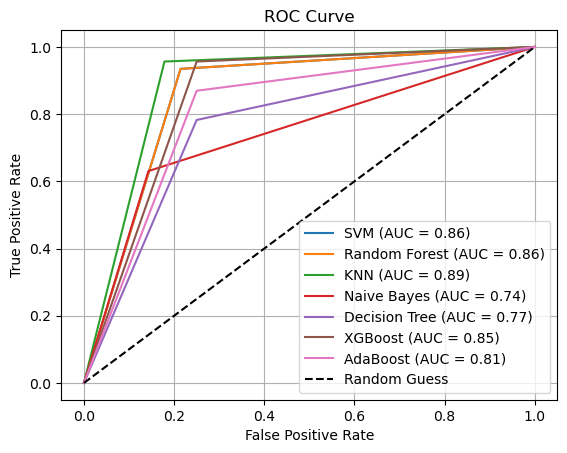

SVM Performance Metrics:
Accuracy: 0.8783783783783784
Precision: 0.8775510204081632
Recall: 0.9347826086956522
F1 Score: 0.9052631578947369
AUC-ROC: 0.860248447204969
Time: 1.7489705085754395

Random Forest Performance Metrics:
Accuracy: 0.8783783783783784
Precision: 0.8775510204081632
Recall: 0.9347826086956522
F1 Score: 0.9052631578947369
AUC-ROC: 0.860248447204969
Time: 103.24543190002441

KNN Performance Metrics:
Accuracy: 0.9054054054054054
Precision: 0.8979591836734694
Recall: 0.9565217391304348
F1 Score: 0.9263157894736843
AUC-ROC: 0.8889751552795031
Time: 2.2625787258148193

Naive Bayes Performance Metrics:
Accuracy: 0.7162162162162162
Precision: 0.8787878787878788
Recall: 0.6304347826086957
F1 Score: 0.7341772151898734
AUC-ROC: 0.7437888198757765
Time: 0.4225144386291504

Decision Tree Performance Metrics:
Accuracy: 0.7702702702702703
Precision: 0.8372093023255814
Recall: 0.782608695652174
F1 Score: 0.8089887640449438
AUC-ROC: 0.7663043478260869
Time: 5.001607894897461

XGBoos

In [12]:
results_female = evaluate_classifiers(X_train_female, y_train_female, X_test_female, y_test_female,'FemaleWithNormalization')

for clf_name, metrics in results_female.items():
    print(clf_name + " Performance Metrics:")
    print("Accuracy:", metrics['accuracy'])
    print("Precision:", metrics['precision'])
    print("Recall:", metrics['recall'])
    print("F1 Score:", metrics['f1'])
    print("AUC-ROC:", metrics['auc'])
    print("Time:", metrics['time_execution'])
    print()

Folder '../Models/MaleWithNormalization' created successfully.
Model for SVM saved.
Classification Report for SVM:
              precision    recall  f1-score   support

         0.0       0.68      0.94      0.79        18
         1.0       0.98      0.87      0.92        60

    accuracy                           0.88        78
   macro avg       0.83      0.91      0.86        78
weighted avg       0.91      0.88      0.89        78

[[17  1]
 [ 8 52]]
Model for Random Forest saved.
Classification Report for Random Forest:
              precision    recall  f1-score   support

         0.0       0.88      0.39      0.54        18
         1.0       0.84      0.98      0.91        60

    accuracy                           0.85        78
   macro avg       0.86      0.69      0.72        78
weighted avg       0.85      0.85      0.82        78

[[ 7 11]
 [ 1 59]]
Model for KNN saved.
Classification Report for KNN:
              precision    recall  f1-score   support

         0.0  

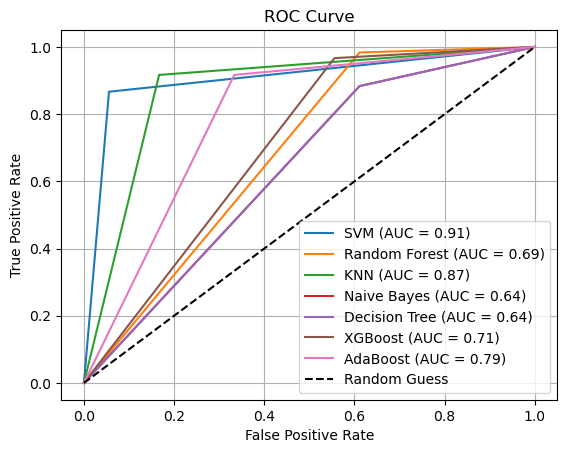

SVM Performance Metrics:
Accuracy: 0.8846153846153846
Precision: 0.9811320754716981
Recall: 0.8666666666666667
F1 Score: 0.9203539823008849
AUC-ROC: 0.9055555555555554
Time: 2.229403018951416

Random Forest Performance Metrics:
Accuracy: 0.8461538461538461
Precision: 0.8428571428571429
Recall: 0.9833333333333333
F1 Score: 0.9076923076923077
AUC-ROC: 0.6861111111111111
Time: 125.2728624343872

KNN Performance Metrics:
Accuracy: 0.8974358974358975
Precision: 0.9482758620689655
Recall: 0.9166666666666666
F1 Score: 0.9322033898305084
AUC-ROC: 0.8749999999999999
Time: 2.0151405334472656

Naive Bayes Performance Metrics:
Accuracy: 0.7692307692307693
Precision: 0.828125
Recall: 0.8833333333333333
F1 Score: 0.8548387096774193
AUC-ROC: 0.6361111111111111
Time: 0.5324561595916748

Decision Tree Performance Metrics:
Accuracy: 0.7692307692307693
Precision: 0.828125
Recall: 0.8833333333333333
F1 Score: 0.8548387096774193
AUC-ROC: 0.6361111111111111
Time: 5.591140031814575

XGBoost Performance Metri

In [13]:
results_male = evaluate_classifiers(X_train_male, y_train_male, X_test_male, y_test_male,'MaleWithNormalization')

for clf_name, metrics in results_male.items():
    print(clf_name + " Performance Metrics:")
    print("Accuracy:", metrics['accuracy'])
    print("Precision:", metrics['precision'])
    print("Recall:", metrics['recall'])
    print("F1 Score:", metrics['f1'])
    print("AUC-ROC:", metrics['auc'])
    print("Time:", metrics['time_execution'])
    print()